In [1]:
!curl https://www.patrickmin.com/binvox/linux64/binvox > binvox
!chmod u+x binvox

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1487k  100 1487k    0     0   104k      0  0:00:14  0:00:14 --:--:--  149k


In [2]:
import matplotlib.pyplot as plt
import trimesh
import numpy as np
import random

In [3]:
original = np.load("datasettest.npy", allow_pickle=True).item()

In [4]:
indices = list(range(original['test']['x'].shape[0]))
random.shuffle(indices)
indices = indices[:3]
indices

[53, 90, 16]

In [26]:
filename1 = "mesa_model_X.stl"
fileout1 = "mesa_model_X.binvox"
filename2 = "mesa_model_original_X.stl"
fileout2 = "mesa_model_original_X.binvox"

In [27]:
!./binvox -d 32 -cb -e $filename1
!./binvox -d 32 -cb -e $filename2


--- [binvox] mesh voxelizer, version 1.35, build #879 on 2022/10/18 17:53:41, running on Linux
--- written by Patrick Min, 2004-2022

  centering model inside unit cube
  using exact voxelization method
loading model file...
MeshFileIdentifier::*create_mesh_file(mesa_model_X.stl)
StlMeshFile::load(mesa_model_X.stl)
read from header [Expor]
type_was_set [0]
  setting type to BINARY
StlMeshFile::load_binary(mesa_model_X.stl)
  will read 4868 triangles
read 4868 triangles
Mesh memory use is 1764 KB (1 MB)
  Mesh::normalize, bounding box: [-3.375, -4.125, -0.125, 1] - [3.125, 3.875, 4.125, 1]
    longest length: 8
  normalization transform:
  (1) translate [3.375, 4.125, 0.125, 1], (2) scale 0.125, (3) translate [0.5, 0.5, 0.5]
  got mesh bounding box [-3.375, -4.125, -0.125, 1] - [3.125, 3.875, 4.125, 1]
Voxels::init(32, 32, 32, 0)
  Voxels::clear
Voxelizer constructor
SimpleMeshView constructor
Voxelizer::set_step_by_step(0)
starting voxelization...
Voxelizer::exact_voxelize
Voxels::pri

In [7]:
import numpy as np

class Voxels(object):
    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order
    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)
def read_header(fp):
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale
def read_as_3d_array(fp, fix_coords=True):
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(np.bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)

In [28]:
with open(fileout1, "rb") as f:
    model1 = read_as_3d_array(f)
    print(model1.data.shape)
with open(fileout2, "rb") as f:
    model2 = read_as_3d_array(f)
    print(model2.data.shape)

(32, 32, 32)
(32, 32, 32)


/tmp/ipykernel_1970/2801752735.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.repeat(values, counts).astype(np.bool)


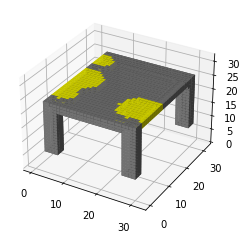

In [30]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(model1.data, facecolors='gray')
ax.voxels(model2.data&~model1.data, facecolors='yellow')
plt.show()

In [31]:
x = [model1.data,]
y = [model2.data,]

for i in indices:
    x.append(original['test']['x'][i])
for i in indices:
    y.append(original['test']['y'][i])

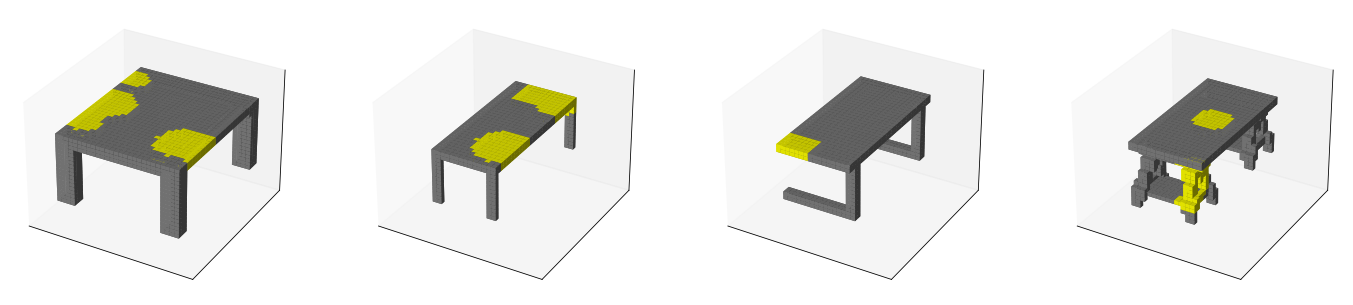

In [34]:
fig = plt.figure()
fig.set_size_inches(6*4, 6)
for i, model in enumerate(x):
    ax = fig.add_subplot(1,4,i+1,projection='3d')
    ax.voxels(model, facecolors='gray')
    ax.voxels(y[i]&~model, facecolors='yellow')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.show()

In [35]:
np.save("datatomodel.npy", {
    "x": x,
    "y": y
})

In [37]:
model_fractured = model1.data
mesh = trimesh.voxel.ops.matrix_to_marching_cubes(matrix=model_fractured, pitch=1.0)
mesh.merge_vertices()
mesh.remove_duplicate_faces()
mesh.apply_scale(scaling=0.25)
trimesh.repair.fill_holes(mesh)
trimesh.repair.fix_inversion(mesh)
trimesh.repair.fix_winding(mesh)

trimesh.exchange.export.export_mesh(mesh=mesh, file_obj=f"mesh.stl", file_type='stl')

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x17\x00\x00:\xcd\x13\xbf:\xcd\x13\xbf:\xcd\x13\xbf\x00\x00@?\x00\x00\x00\x00\x00\x00\xd0?\x00\x00@?\x00\x00\x00\xbe\x00\x00\xe0?\x00\x00 ?\x00\x00\x00\x00\x00\x00\xe0?\x00\x00\xf3\x045\xbf\xf3\x045\xbf\x00\x00\x00\x00\x00\x00@?\x00\x00\x00\xbe\x00\x00\x00@\x00\x00 ?\x00\x00\x00\x00\x00\x00\xe0?\x00\x00@?\x00\x00\x00\xbe\x00\x00\xe0?\x00\x00\xf3\x045\xbf\xf3\x045\xbf\x00\x00\x00\x80\x00\x00@?\x00\x00\x00\xbe\x00\x00\x00@\x00\x00 ?\x00\x00\x00\x00\x00\x00\x00@\x00\x00 ?\x00\x00\x00\x00\x00\x00\xe0?\x00\x00\xf3\x045\xbf\xf3\x045\xbf\x00\x00\x00\x00\x00\x00@?\x00\x00\x00\xbe\x00\x00\x10@\x00\x00 ?\x00\x00\x00\x00\x00\x00\x00@\x00\x00@?\x00\x00\x00\xbe\x00\x00\x00@\x00\